In [18]:
import json
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
from scipy.stats import chi2_contingency
from textblob import TextBlob

# Prompt Analysis

## Analysis of prompt embeddings

We will begin analyzing the prompts generated by the LLM to see whether there is a certain trademark of "politeness" that shows up in the embedding model. To do that, we will first examine the pairwise cosine similarities of the differences between corresponding polite and neutral prompts. Large positive values for cosine similarity across pairs of difference vectors indicate that the effect of making a prompt "polite" is captured in the embedding. We will examine cosine similarity for both the polite prompts with "please" and without "please". We will also examine whether the effects of politeness differ across categories by looking at how the difference vectors cluster across categories.

In [3]:
def load_prompts(filename):
    with open(filename, 'r') as file:
        return json.load(file)

In [4]:
# Load in the various categories of prompts
technical_prompts = load_prompts("prompts/technical_prompts.json")
art_lit_prompts = load_prompts("prompts/art_lit_prompts.json")
personal_prompts = load_prompts("prompts/personal_prompts.json")
everyday_prompts = load_prompts("prompts/everyday_prompts.json")

In [5]:
# Combine all categories
category_prompts = [[technical_prompts, "Technical"],
                    [art_lit_prompts, "Art Lit "],
                    [personal_prompts, "Personal"],
                    [everyday_prompts, "Everyday"]]

prompts = {}

for category in category_prompts:
    prompts.update({f'{category[1]} {key}': value for key, value in category[0].items()})

In [6]:
# Total length should be 4 * 30 = 120
len(prompts)

120

In [7]:
# Initialize the sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to generate embeddings for the prompts
def generate_embeddings(prompts):
    embeddings = model.encode(prompts, convert_to_tensor=True)
    return embeddings

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
neutral_prompts_list = [p['Neutral'] for p in prompts.values()]
polite_please_prompts_list = [p['Polite with please'] for p in prompts.values()]
polite_no_please_prompts_list = [p['Polite without please'] for p in prompts.values()]

# Get embeddings for each tone of prompt
neutral_embeddings = generate_embeddings(neutral_prompts_list)
polite_please_embeddings = generate_embeddings(polite_please_prompts_list)
polite_no_please_embeddings = generate_embeddings(polite_no_please_prompts_list)

# This will give us an n*d Tensor, where n is the number of neutral prompts generated and d is the dimensionality of each embedding
neutral_embeddings.shape

torch.Size([120, 384])

In [9]:
# We'll look at only polite with please, only polite without please, and both at the same time.
polite_please_differences = polite_please_embeddings - neutral_embeddings
polite_no_please_differences = polite_no_please_embeddings - neutral_embeddings

difference_vectors = torch.cat((polite_please_differences, polite_no_please_differences), dim=0)

polite_please_similarity_matrix = util.cos_sim(polite_please_differences, polite_please_differences)
polite_no_please_similarity_matrix = util.cos_sim(polite_no_please_differences, polite_no_please_differences)
similarity_matrix = util.cos_sim(difference_vectors, difference_vectors)

# This should be a n*n Tensor, with 1's along the main diagonal
polite_please_similarity_matrix.shape

torch.Size([120, 120])

<Axes: >

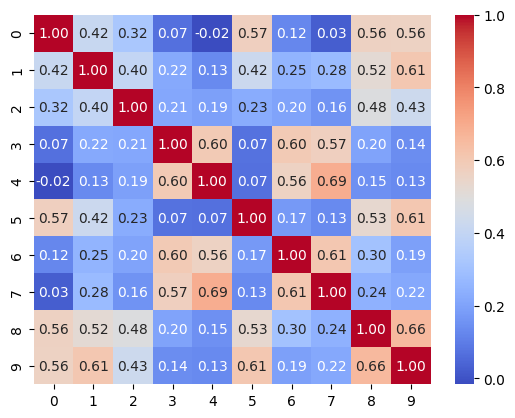

In [10]:
# Let's plot the first 10x10 entries of similarity_matrix as a heatmap:
sns.heatmap(similarity_matrix[:10, :10], annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

As we can see above, while certain pairs of prompts display large similarities to each other, most of them are in the range of around .1 to .3 Let's look at this distribution further, and - to get a sense of how "significant" these values may be - compare it to the cosine similarity of a random Tensor that shares the same variance with difference_vectors.

In [11]:
# In order to apply the appropriate mask to remove diagonal elements, we'll need to convert similarity_matrix to a numpy array.
similarity_matrix_np = similarity_matrix.cpu().detach().numpy()
# Let's take just the upper triangle indices to avoid repeats
upper_triangle_indices = np.triu_indices_from(similarity_matrix_np, k=1)
similarity_matrix_upper_triangle = similarity_matrix_np[~np.eye(similarity_matrix.shape[0], dtype=bool)]
similarity_matrix_upper_triangle = similarity_matrix_np[upper_triangle_indices]


# Assuming difference_vectors is a torch tensor with your difference vectors
# Compute the std of the difference vectors
diff_vector_std = torch.std(difference_vectors, dim=0)

# Generate a larger random sample with the same variance
# as the difference_vectors
random_tensor = torch.randn((1000, difference_vectors.shape[1])) * diff_vector_std
random_similarity_matrix = util.cos_sim(random_tensor, random_tensor).cpu().numpy()

# Extract the upper triangle of the similarity matrix
random_similarity_upper_triangle = random_similarity_matrix[np.triu_indices_from(random_similarity_matrix, k=1)]

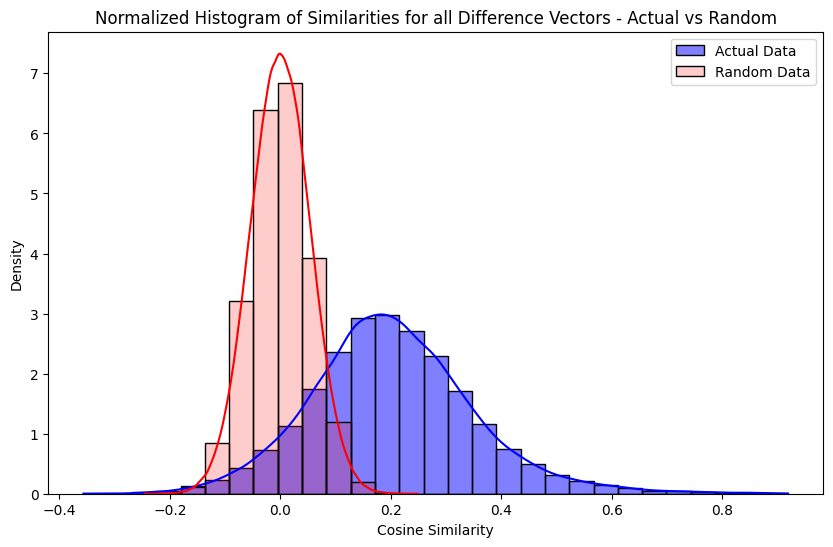

In [12]:
# Define a common bin range based on the combined range of both actual and random data
combined_data = np.concatenate([similarity_matrix_upper_triangle, random_similarity_upper_triangle])
bin_range = np.linspace(np.min(combined_data), np.max(combined_data), num=30)

# Plotting the normalized histogram for actual data and random data
plt.figure(figsize=(10, 6))
sns.histplot(similarity_matrix_upper_triangle, bins=bin_range, kde=True, color='blue', label='Actual Data', stat='density')
sns.histplot(random_similarity_upper_triangle, bins=bin_range, kde=True, color='red', alpha=0.2, label='Random Data', stat='density')
plt.title('Normalized Histogram of Similarities for all Difference Vectors - Actual vs Random')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

The analysis above indicates that the embedding model captures some aspects of the change in tone due to politeness achieved both through the usage of the word "please" and through other means, suggesting something systematic about the way the embeddings model tends to process the changes in tone. Next, let's compare the average difference vectors for polite with "please" and polite without "please":

In [13]:
mean_please_dif = polite_please_differences.mean(dim=1)
mean_no_please_dif = polite_no_please_differences.mean(dim=1)

# Similarity of average difference
util.cos_sim(mean_please_dif, mean_no_please_dif)

tensor([[0.4020]])

It appears that there is quite significant similarity between the two, further indicating overlap between embeddings of "politeness" independent of syntax and word choice used to achieve the tone. Something that we might be interested in is looking at the average magnitude of the effect of politeness (as a percentage to the neutral prompt embedding magnitude). While not having a direct interpretable effect, this tells us to what extent politeness affects the embedding, which could serve as a proxy for its semantic significance.

In [14]:
neutral_magnitudes = torch.norm(neutral_embeddings, dim=1, keepdim=True)
polite_please_dif_magnitudes = torch.norm(polite_please_differences, dim=1, keepdim=True)
polite_no_please_dif_magnitudes = torch.norm(polite_no_please_differences, dim=1, keepdim=True)

please_dif_pct_change = (polite_please_dif_magnitudes / neutral_magnitudes).mean().item() * 100
no_please_dif_pct_change = (polite_no_please_dif_magnitudes / neutral_magnitudes).mean().item() * 100

# Print the formatted values obtained
print(f"Percentage Change in Embedding Magnitude for Polite with 'Please': {please_dif_pct_change:.2f}%")
print(f"Percentage Change in Embedding Magnitude for Polite Without 'Please': {no_please_dif_pct_change:.2f}%")

Percentage Change in Embedding Magnitude for Polite with 'Please': 27.99%
Percentage Change in Embedding Magnitude for Polite Without 'Please': 41.66%


Politeness changes the embedding significantly, though notably also substantially less than the original magnitude of the embedding itself. The magnitude of changes for polite without "please" are on average larger than those for polite with "please", perhaps owing to the variety of syntactical changes the LLM made to many of the prompts in order to achieve politeness without "please". For instance, the neutral prompt 2 in "everyday prompts" is "Can you recommend a good restaurant in this area?", which retains the same syntactic structure in the polite version with "please" ("Can you please recommend a good restaurant in this area?"), but gets reworked in the polite version without please ("I would like to ask for your recommendation on a good restaurant in this area.")

Let's now turn our attention towards comparing the direct effects of politeness across different categories, restricting ourselves to polite prompts using the word "please" (in order to control for indirect effects of politeness that arise from categorical heterogeneity in employed syntax). We will examine this in two ways. First, we will look at the average cross-category cosine similarities, as compared to the average within-category cosine similarities. Second, we will develop an unsupervised clustering algorithm for the differences vectors, and examine how the clustering aligns with category.

In [15]:
PROMPTS_PER_CATEGORY = 30

# Step 1: Label Difference Vectors with Categories
category_labels = ['Technical', 'Art Lit', 'Personal', 'Everyday']
category_indices = {label: list(range(i * PROMPTS_PER_CATEGORY, (i + 1) * PROMPTS_PER_CATEGORY)) for i, label in enumerate(category_labels)}

# Step 2: Compute Within-Category and Cross-Category Cosine Similarities
within_category_similarities = {label: [] for label in category_labels}
cross_category_similarities = {label: [] for label in category_labels}

for category in category_labels:
    indices = category_indices[category]
    within_diffs = polite_please_differences[indices]
    
    # Within-category similarities
    within_sim_matrix = util.cos_sim(within_diffs, within_diffs).cpu().numpy()
    np.fill_diagonal(within_sim_matrix, np.nan)  # Ignore self-comparisons
    within_category_similarities[category] = np.nanmean(within_sim_matrix)
    
    # Cross-category similarities
    for other_category in category_labels:
        if other_category != category:
            other_indices = category_indices[other_category]
            cross_diffs = polite_please_differences[other_indices]
            cross_sim_matrix = util.cos_sim(within_diffs, cross_diffs).cpu().numpy()
            cross_category_similarities[category].append(np.mean(cross_sim_matrix))

# Step 3: Average the Similarities
avg_within_category_similarities = {k: np.mean(v) for k, v in within_category_similarities.items()}
avg_cross_category_similarities = {k: np.mean(v) for k, v in cross_category_similarities.items()}

# Display the results
print("Average Within-Category Similarities:")
print(avg_within_category_similarities)
print("\nAverage Cross-Category Similarities:")
print(avg_cross_category_similarities)

Average Within-Category Similarities:
{'Technical': 0.34747797, 'Art Lit': 0.42937988, 'Personal': 0.28132018, 'Everyday': 0.31784716}

Average Cross-Category Similarities:
{'Technical': 0.21406007, 'Art Lit': 0.2636834, 'Personal': 0.21856008, 'Everyday': 0.21823387}


Interestingly, the average within-category similarities between difference vectors are much higher than the average cross-category similarities, indicating that politeness, or at least politeness achieved with the word "please", may have different tonal effects depending on the context it is being used in. We will revisit this theme when we look at the effects of politeness on the responses generated to the prompts, and how those effects vary across prompt category. Let's create a heatmap to visualize this more precisely:

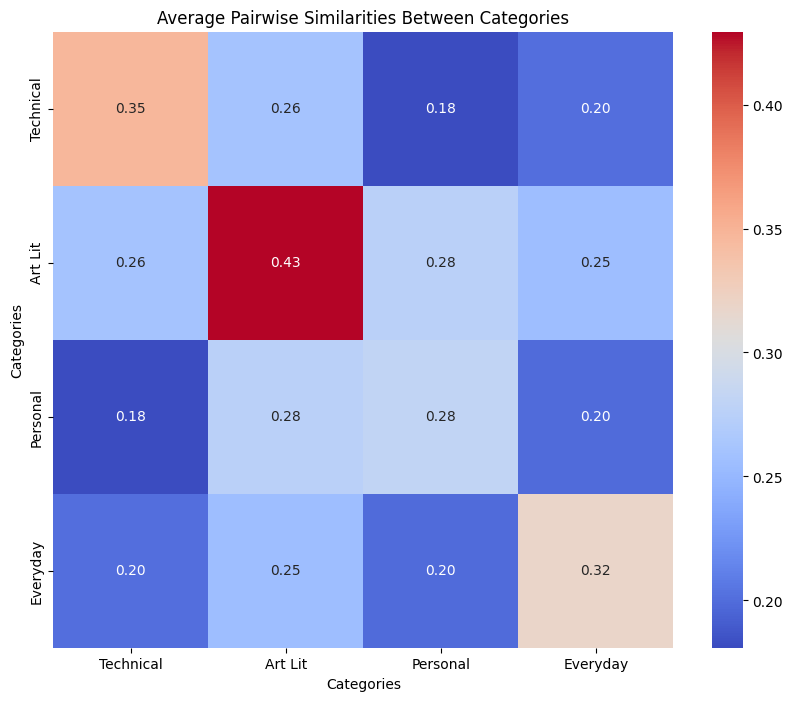

In [19]:
# Heatmap showing average pairwise within- and cross- category similarities

# Initialize the matrix with zeros
num_categories = len(category_labels)
cross_category_similarity_matrix = np.zeros((num_categories, num_categories))

for i, category_i in enumerate(category_labels):
    cross_index = 0  # Index for accessing cross_category_similarities
    for j, category_j in enumerate(category_labels):
        if i == j:
            # Diagonal entries represent within-category similarities
            cross_category_similarity_matrix[i, j] = avg_within_category_similarities[category_i]
        else:
            # Average cross-category similarities
            cross_category_similarity_matrix[i, j] = cross_category_similarities[category_i][cross_index]
            cross_index += 1

# Step 2: Create and Display the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cross_category_similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
            xticklabels=category_labels, yticklabels=category_labels)
plt.title('Average Pairwise Similarities Between Categories')
plt.xlabel('Categories')
plt.ylabel('Categories')
plt.show()


Let's see if categorization shows up in a k-means classifier (with 4 means to match the 4 categories) on the data:

In [20]:
# Convert the difference_vectors to a numpy array
difference_vectors_np = difference_vectors.cpu().detach().numpy()  # Assuming they are on GP

# Perform PCA for Dimensionality Reduction
pca = PCA(n_components=10)  # Reduce to 10 dimensions
pca_result = pca.fit_transform(polite_please_differences.cpu().detach().numpy())

# K-means Clustering on PCA Results
kmeans = KMeans(n_clusters=4, random_state=0).fit(pca_result)
labels = kmeans.labels_

# Compute 2-dimensional t-SNE for Scatterplot Visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[t-SNE] Computing 119 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 0.113150
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.418472
[t-SNE] KL divergence after 300 iterations: 0.324897


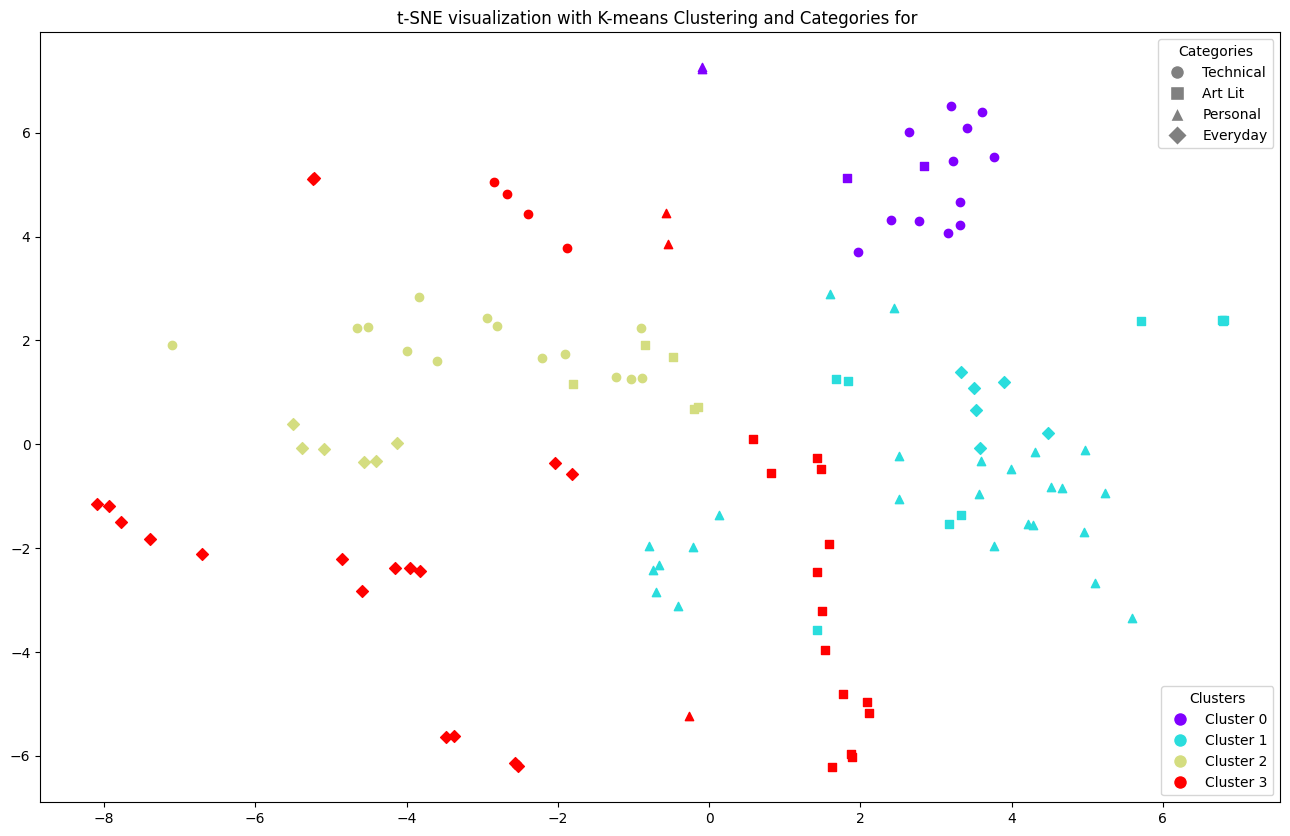

In [111]:
# Visualization

# Step 1: Assign Markers for Each Category
category_markers = ['o', 's', '^', 'D']  # For example, circle, square, triangle up, diamond
category_descriptions = ['Technical', 'Art Lit', 'Personal', 'Everyday']

# Initialize a color map for clusters
colors = cm.rainbow(np.linspace(0, 1, 4))

# Step 2: Plot t-SNE Results with Cluster Colors and Category Markers
plt.figure(figsize=(16,10))

for category_index, (category_label, marker) in enumerate(zip(category_descriptions, category_markers)):
    indices = category_indices[category_label]  # Indices of the prompts in the current category
    category_tsne_results = tsne_results[indices, :]
    category_labels = labels[indices]
    
    for cluster_index in range(4):
        cluster_indices = category_tsne_results[category_labels == cluster_index, :]
        plt.scatter(cluster_indices[:, 0], cluster_indices[:, 1], color=colors[cluster_index], marker=marker, label=f'Cluster {cluster_index}, {category_label}' if category_index == 0 else "")

plt.title('t-SNE visualization with K-means Clustering and Categories for ')

# Legend for categories (marker shapes)
category_legend = [Line2D([0], [0], marker=marker, color='w', label=category_desc, markersize=10, markerfacecolor='gray') for marker, category_desc in zip(category_markers, category_descriptions)]

# Legend for clusters (colors)
cluster_legend = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}', markersize=10, markerfacecolor=color) for i, color in enumerate(colors)]

# Combine legends and add them to the plot
legend1 = plt.legend(handles=category_legend, loc='upper right', title='Categories')
legend2 = plt.legend(handles=cluster_legend, loc='lower right', title='Clusters')

# Add legend1 back after legend2 overrides it
plt.gca().add_artist(legend1)
plt.show()

It appears as though there is significant - albeit weak - association between the clustering and the categorization, again demonstrating heterogeneity in the embedding effects of politeness across prompt categories. To measure this asssociation (and its significance) analytically, we can use a Chi-squared test:

In [21]:
contingency_table = np.zeros((num_categories, 4))  # 4 clusters, num_categories categories

for category_index, (category_label, indices) in enumerate(category_indices.items()):
    category_cluster_labels = labels[indices]
    
    for cluster_index in range(4):
        # Count how many prompts in this category are in this cluster
        count = np.sum(category_cluster_labels == cluster_index)
        contingency_table[category_index, cluster_index] = count

# Step 2: Perform the Chi-squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Step 3: Interpret the Results
print(f"Chi-squared Statistic: {chi2}")
print(f"p-value: {p}")


Chi-squared Statistic: 89.21743589743589
p-value: 2.336877269284884e-15


## Sentiment Analysis with TextBlob

While sentiment analysis will become more useful for us when analyzing the responses of the prompts, it is interesting to look at how politeness affects the sentiment of the prompts themselves.

textblob is a library for performing common NLP tasks on text, including sentiment analysis. Running the TextBlob() method on a piece of text will return a Sentiment object with polarity and subjectivity scores. The polarity score measures the sentiment expressed in the text ranging from -1 (negative sentiment) to +1 (positive sentiment), while the subjectivity represents the amount of personal opinion and factual information contained in the text. Seeing as we are dealing with prompts that are interrogative in nature, we focus only on the polarity score. When analyzing responses to the prompts, we will look at both polarity and subjectivity.

In [133]:
# Function to get sentiment
def get_sentiment(text):
    testimonial = TextBlob(text)
    # testimonial.sentiment will return a Sentiment object with polarity 
    return testimonial.sentiment.polarity

# Analyzing sentiment of each type of prompt
polarities_neutral = [get_sentiment(prompt['Neutral']) for prompt in prompts.values()]
polarities_polite_please = [get_sentiment(prompt['Polite with please']) for prompt in prompts.values()]
polarities_polite_no_please = [get_sentiment(prompt['Polite without please']) for prompt in prompts.values()]

Let's visualize these distributions using boxplots:

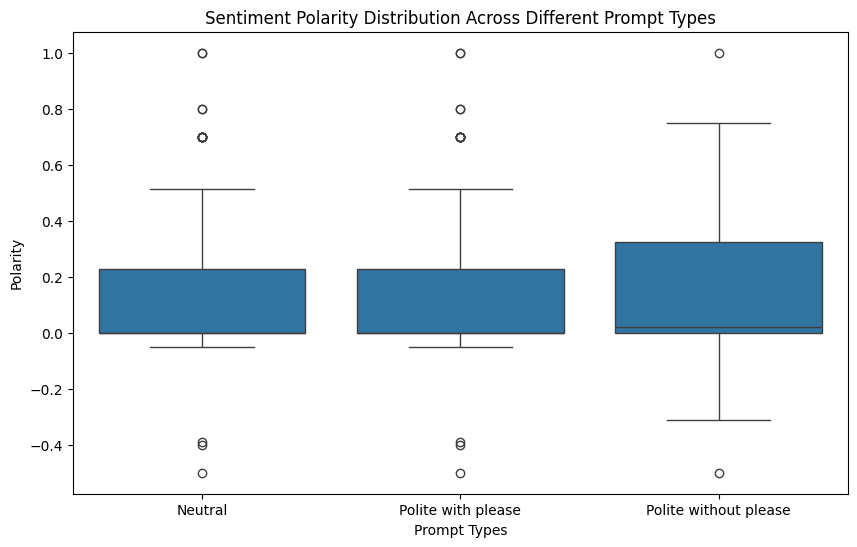

In [134]:
# Visualization of Polarity

polarities = polarities_neutral + polarities_polite_please + polarities_polite_no_please
types = ['Neutral'] * len(polarities_neutral) + ['Polite with please'] * len(polarities_polite_please) + ['Polite without please'] * len(polarities_polite_no_please)

plt.figure(figsize=(10, 6))
sns.boxplot(x=types, y=polarities)
plt.title('Sentiment Polarity Distribution Across Different Prompt Types')
plt.ylabel('Polarity')
plt.xlabel('Prompt Types')
plt.show()

Interestingly enough, it appears as if the presence of "please" in the prompts hardly affects the polarity score. This will be very interesting to note when comparing with the responses generated to the prompts. However, the distribution for "polarity without please" appears to be somewhat different from the neutral. Let's examine this further by looking at pairwise differences in polarity between polite and neutral prompts:

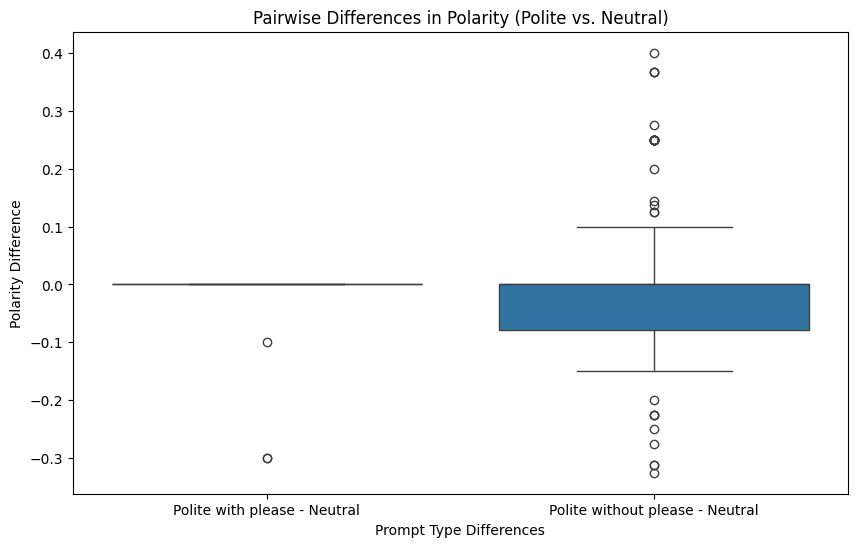

In [135]:
# Calculate pairwise differences
pairwise_diffs_please = [polite - neutral for polite, neutral in zip(polarities_polite_please, polarities_neutral)]
pairwise_diffs_no_please = [polite - neutral for polite, neutral in zip(polarities_polite_no_please, polarities_neutral)]

# Combine the differences and labels for plotting
pairwise_diffs = pairwise_diffs_please + pairwise_diffs_no_please
diff_types = ['Polite with please - Neutral'] * len(pairwise_diffs_please) + ['Polite without please - Neutral'] * len(pairwise_diffs_no_please)

plt.figure(figsize=(10, 6))
sns.boxplot(x=diff_types, y=pairwise_diffs)
plt.title('Pairwise Differences in Polarity (Polite vs. Neutral)')
plt.ylabel('Polarity Difference')
plt.xlabel('Prompt Type Differences')
plt.show()


It appears as though "please" rarely affects the polarity, and polite without "please" can have both positive and negative effects on the polarity, once again likely owing to the syntactic changes made to the prompts. These results provide useful baslines to which we can compare the respones generated to the prompts.

# Prompt Response Analysis

n.b.: A few of the responses to the prompts in the Art & Literature section are along the lines of "As an AI model, ...". I've kept those in for now, as I did nonetheless observe differences in the specific word choice employed in the responses across the three versions of the same prompt.

## Response Length

## LLM Evaluation

## Response Sentiment Analysis

## Response Embedding Analysis

In [31]:
import random
def eval_prompt(prompt, response):
    choices = random.shuffle(['Polite', 'Neutral'])
    eval_prompt_template = f"""
    In two separate (blank) threads, I asked you semantically similar prompts with different
    tones. These prompts were the following: \n
    Neutral prompt: \"{prompt['Neutral']}\" \n
    Polite prompt with 'please': \"{prompt['Polite']}\" \n

    Below, I will present the responses you gave to each of these prompts, in a randomized order.
    I would like you to compare the responses both qualitatively (e.g. one is more in-depth than
    the other, one seems to be suited for different  audiences than the other, etc.) and quantitatively,
    by giving each response a score on a scale from 0 to 10 (1 decimal point) in terms of how effectively
    it answers both the NEUTRAL prompt and the POLITE prompt.

    Here are the two responses:
    \n Response 1: \n
    {response[choices[0]]}

    \n Response 2: \n
    {response[choices[1]]}
    """

In [6]:
import random

In [27]:
random.shuffle()

In [28]:
x = [1, 2, 5]

In [29]:
random.shuffle(x)

In [30]:
x

[5, 2, 1]

In [1]:
sns.__version__

NameError: name 'sns' is not defined